In [45]:
import pandas as pd
import os

topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
cleandir = os.path.join(topdir, 'data/Cleaned')

accomodate_path = os.path.join(cleandir, 'PrePilotAccomodate.csv')
predict_path   = os.path.join(cleandir, 'PrePilotPredict.csv')

df_accomodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accomodate['task'] = 'accomodate'
df_predict['task']   = 'predict'


print("Accomodate columns:", df_accomodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accomodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'image_order', 'ratings', 'categories', 'conditionOrder', 'training_image_order', 'shape_discrete_slider.response', 'color_discrete_slider.response', 'tail_discrete_slider.response', 'shape_direction_slider.response', 'color_direction_slider.response', 'tail_direction_slider.response', 'shape_continuous_slider.response', 'color_continuous_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'train_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'image_order', 'ratings', 'categories', 'conditionOrder', 'training_image_order', 'shape_discrete_slider.response', 'color_discrete_slider.response', 'tail_discrete_slider.response', 'shape_direction_slider.response', 'color_direction_slider.response', 'tail_direction_slider.response', 'shape_continuous_slider.response', 'color_continuous_slider.response', 'tail_continuous_slider.response', '

In [50]:
print(df_accomodate['image_order'])

0    ['T_B_S', 'T_B_C', 'N_B_C', 'N_Y_C', 'N_B_S', ...
1    ['N_Y_C', 'N_B_C', 'N_Y_S', 'T_B_C', 'T_B_S', ...
2    ['N_B_C', 'T_Y_C', 'T_B_C', 'N_B_S', 'N_Y_C', ...
3    ['T_Y_S', 'T_B_S', 'N_Y_C', 'N_Y_S', 'N_B_S', ...
4    ['T_Y_S', 'N_B_S', 'N_Y_C', 'T_B_C', 'T_Y_C', ...
5    ['T_B_C', 'N_B_C', 'N_Y_C', 'T_Y_S', 'T_B_S', ...
Name: image_order, dtype: object


In [52]:
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accomodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)


In [53]:
#Look at average time across task

avg_time = df_combined.groupby(['task'])['trial_stop_time'].mean()
print(avg_time)

task
accomodate    564.230717
predict       378.904150
Name: trial_stop_time, dtype: float64


In [ ]:
import ast
import matplotlib.pyplot as plt
def AverageFoodCalclator(participants_to_use):
    df_subset = df_combined[df_combined['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        trial_order = ast.literal_eval(df_subset[df_subset['participant'] == i]['image_order'].iloc[0])
        ratings     = ast.literal_eval(df_subset[df_subset['participant'] == i]['ratings'].iloc[0])
        categories = ast.literal_eval(df_subset[df_subset['participant'] == i]['categories'].iloc[0])
        task = df_subset[df_subset['participant'] == i]['task'].iloc[0]
        df_participant = pd.DataFrame(list(zip(
            [i]*len(trial_order),  # Repeat participant ID and task to match the number of trials
            trial_order,
            ratings,
            [task]*len(trial_order), # Repeat participant ID and task to match the number of trials
            categories,
        )), columns=['participant', 'image', 'ratings', 'task', 'category'])
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings_cond = df_average.groupby(['task', 'category'])['ratings'].mean()
    avg_ratings_image = df_average.groupby(['task', 'image', 'category'])['ratings'].mean()
    return df_average, avg_ratings_cond, avg_ratings_image

participants_to_use = df_combined['participant'].tolist()
df_average, avg_rating_cond, avg_rating_image = AverageFoodCalclator(participants_to_use)
print(avg_rating_cond)
print(avg_rating_image)




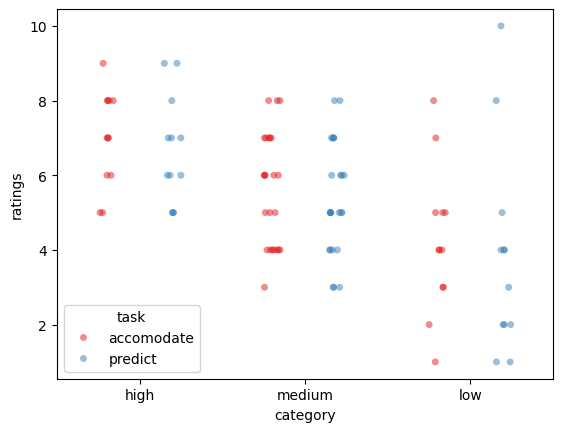

In [55]:
import seaborn as sns
sns.stripplot(data=df_average, x='category', y='ratings', hue='task', 
              palette='Set1', dodge=True, jitter=True, color='black', alpha=0.5)
plt.savefig('PrePilotPlots/CategoryStripPlot.png')


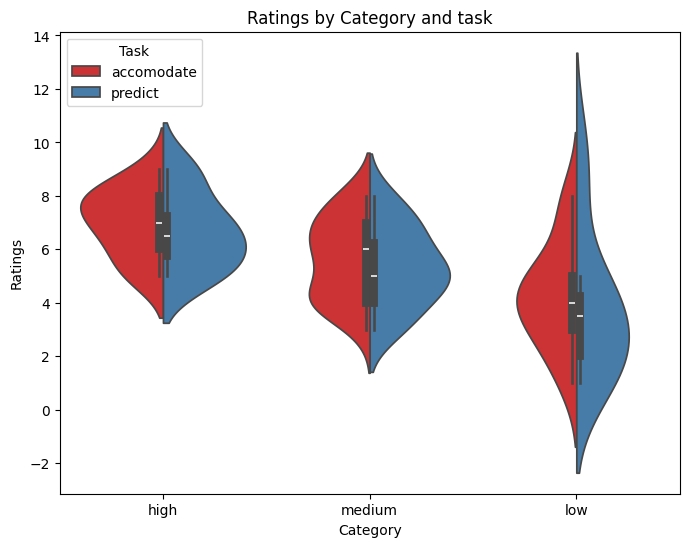

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot: ratings by category, separated by task
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df_average,
    x='category',       # x-axis: categories
    y='ratings',        # y-axis: ratings
    hue='task',         # split by task
    split=True,         # split the violins by task
    palette='Set1',
    inner='box'    # show box plot of data inside
)

plt.ylabel('Ratings')
plt.xlabel('Category')
plt.title('Ratings by Category and task')
plt.legend(title='Task')
plt.show()

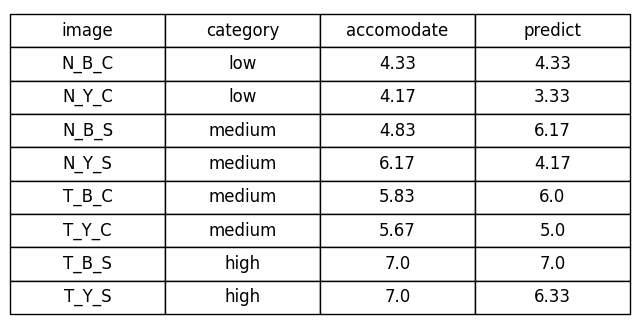

In [16]:
category_order = ['low', 'medium', 'high']
df_table = avg_rating_image.unstack(level=0).reset_index().round(2)
df_table['category'] = pd.Categorical(df_table['category'], categories=category_order, ordered=True)
df_table = df_table.sort_values('category').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,4))
ax.axis('off')  # no axes for a table

# create table
tbl = ax.table(cellText=df_table.values,
               colLabels=df_table.columns,
               cellLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 2)  # scale width and height

plt.savefig('PrePilotPlots/AverageRatingsTable.png', bbox_inches='tight')
plt.show()

In [ ]:
import ast
import numpy as np
import pandas as pd

def check_last_n_influence(participant_row, n_last=3):
    """
    Check how the last N training items (food_amount) influence the ratings
    given to those items by the participant.
    """
    # Convert stringified lists
    food_amounts = ast.literal_eval(participant_row['food_amount'])
    training_images = ast.literal_eval(participant_row['training_image_order'])
    ratings = ast.literal_eval(participant_row['ratings'])
    rated_images = ast.literal_eval(participant_row['image_order'])
    
    # Last n items from training
    last_food_amounts = food_amounts[-n_last:]
    last_training_images = training_images[-n_last:]
    
    # Find indices in rated_images corresponding to last training images
    indices_in_rated = [rated_images.index(img) for img in last_training_images]
    corresponding_ratings = [ratings[i] for i in indices_in_rated]
    
    # Print for inspection
    print(f"Participant {participant_row['participant']}")
    print("Last N food amounts:", last_food_amounts)
    print("Corresponding training images:", last_training_images)
    print("Ratings given for these images:", corresponding_ratings)
    print("-"*40)
    
    return last_food_amounts, corresponding_ratings

# Loop over all participants
results = []
for idx, row in df_combined.iterrows():
    last_food, last_ratings = check_last_n_influence(row, n_last=3)
    results.append({
        'participant': row['participant'],
        'last_food': last_food,
        'last_ratings': last_ratings
    })

# Convert to DataFrame if desired
df_last_n_influence = pd.DataFrame(results)
print(df_last_n_influence)


Participant 1
Last N food amounts: [6.0, 4.0, 2.0]
Corresponding training images: ['N_B_C', 'N_Y_S', 'N_B_C']
Ratings given for these images: [3.0, 7.0, 3.0]
----------------------------------------
Participant 2
Last N food amounts: [6.0, 1.0, 10.0]
Corresponding training images: ['T_B_C', 'N_Y_C', 'T_Y_S']
Ratings given for these images: [7.0, 4.0, 6.0]
----------------------------------------
Participant 3
Last N food amounts: [6.0, 7.0, 2.0]
Corresponding training images: ['T_B_C', 'N_Y_S', 'N_Y_C']
Ratings given for these images: [6.0, 8.0, 7.0]
----------------------------------------
Participant 4
Last N food amounts: [6.0, 5.0, 1.0]
Corresponding training images: ['T_Y_S', 'T_Y_C', 'N_B_C']
Ratings given for these images: [7.0, 5.0, 2.0]
----------------------------------------
Participant 5
Last N food amounts: [2.0, 5.0, 8.0]
Corresponding training images: ['N_B_C', 'T_B_C', 'T_Y_S']
Ratings given for these images: [5.0, 7.0, 8.0]
----------------------------------------
Part